<Figure size 10000x10000 with 0 Axes>

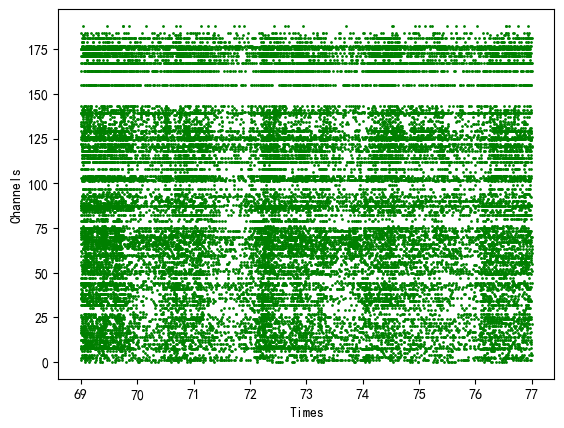

In [41]:
import matplotlib.pyplot as plt
import hdf5storage
import numpy as np

plt.figure(figsize=(100, 100))
mat_data = hdf5storage.loadmat('indy_20160407_02.mat')
ch_names = mat_data['chan_names'].reshape(-1)
cursor_pos = mat_data['cursor_pos']
finger_pos = mat_data['finger_pos']
sp = mat_data['spikes']
timestamps = mat_data['t']
target_pos = mat_data['target_pos']
wf = mat_data['wf']
fig, ax = plt.subplots()
ax.set_xlabel('Times')
ax.set_ylabel('Channels')
for un in range(3):S
    for unit, times in enumerate(sp[:,un]):
        if times.size==0 or unit >192:
            continue
        ind = np.where((times > timestamps[1000]) & (times < timestamps[3000]))[0]
        plot_t = times[ind]
        ax.scatter(plot_t, [unit] * len(plot_t), s=1, color='green')

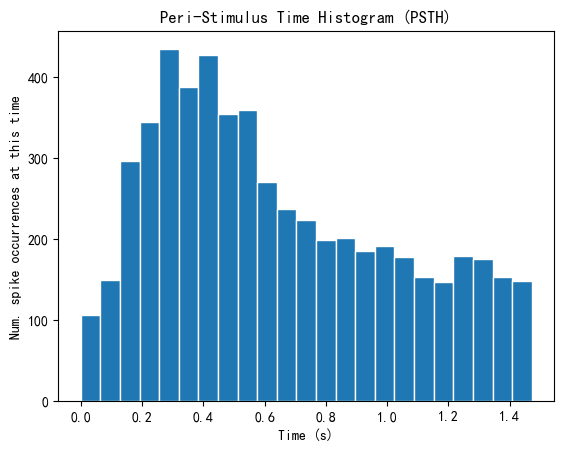

In [42]:
times_bin_list = np.arange(timestamps[0], timestamps[-1], 0.064)
dur_time = 20*0.064+0.2
dif = np.diff(target_pos, axis=0)
indx = np.where(np.any(dif!=0, axis=1))[0]
indx = indx + 1
indx = np.insert(indx, 0, 0)
st_time = timestamps[indx]
select_un = sp[3,1]
h_x_list = np.arange(0, dur_time, 0.064)
bin_centers = h_x_list[:-1] + np.diff(h_x_list) / 2
spike_cnt_list = []
for i in range((h_x_list.shape[0])-1):
    cur_spike=0
    for time in st_time:
        cur_spike += select_un[ (select_un>=time+h_x_list[i]) & (select_un< time+h_x_list[i+1]) ].shape[0]
    spike_cnt_list.append(cur_spike)
fig, ax = plt.subplots()
plt.hist(bin_centers, bins=h_x_list, weights=np.array(spike_cnt_list),
edgecolor='white')
ax.set_title('Peri-Stimulus Time Histogram (PSTH)')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Num. spike occurrences at this time')
plt.show()

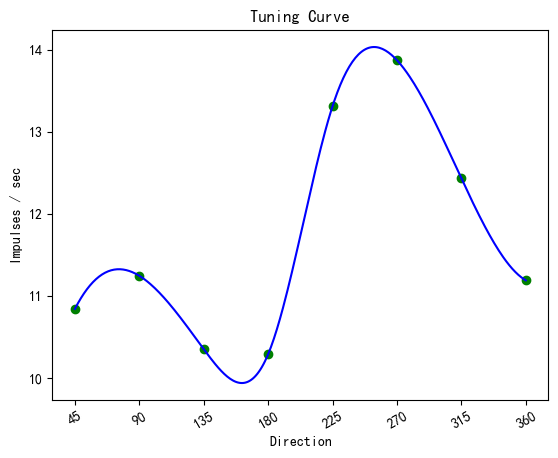

In [47]:
import matplotlib.pyplot as plt
import numpy as np
import hdf5storage
import math
from scipy.interpolate import make_interp_spline

# Set plot style
plt.rcParams['font.sans-serif'] = ['SimHei'] 
plt.rcParams['axes.unicode_minus'] = False 

# Load data
file = 'indy_20160407_02.mat'
data = hdf5storage.loadmat(file, mat_dtype=True)
target_pos = data['target_pos']
cursor_pos = data['cursor_pos']
wf = (np.array([data['wf'][32][0]])).reshape(8092, 48)
wf1 = (np.array([data['wf'][32][1]])).reshape(9652, 48)
wf2 = (np.array([data['wf'][32][2]])).reshape(5310, 48)
t = data['t']
spike = (np.array([data['spikes'][32][1]])).reshape(9652, 1)

# Initialize target location and time
target_loc = [-30, 56.4286]
target_time = []
for i in range(cursor_pos.shape[0]):
    if math.sqrt((target_loc[0] - cursor_pos[i, 0])**2 + (target_loc[1] - cursor_pos[i, 1])**2) < 1:
        target_time.append(i)

# Raster matrix creation
raster_matrix = np.zeros((10, 1000))
valid_target_time = np.array([290.824, 347.264, 357.304, 365.276, 432.164, 447.608, 607.404, 655.524, 854.544, 857.008])
for i in range(valid_target_time.shape[0]):
    count = 0
    for j in spike:
        if valid_target_time[i] - 0.2 < j < valid_target_time[i] + 1.2:
            raster_matrix[i, count] = j - valid_target_time[i]
            count += 1

# Determine target positions and angles
all_position = [target_pos[0, :]]
time_position = []
for i in range(1, target_pos.shape[0]):
    if not (target_pos[i, 0] == target_pos[i - 1, 0] and target_pos[i, 1] == target_pos[i - 1, 1]):
        all_position.append(target_pos[i, :])
        time_position.append(t[i])

all_position = np.array(all_position)
time_position = np.array(time_position)
all_angle = []
for i in range(time_position.shape[0]):
    if i == 0:
        dx = all_position[i, 0] - 42.1102
        dy = all_position[i, 1] - 58.5562
    else:
        dx = all_position[i, 0] - all_position[i - 1, 0]
        dy = all_position[i, 1] - all_position[i - 1, 1]

    angle = math.atan2(dy, dx)
    all_angle.append(math.degrees(angle) % 360)

all_angle = np.array(all_angle)

# Categorizing angles into positions
angle_positions = [[] for _ in range(8)]
for i, angle in enumerate(all_angle):
    index = int(angle // 45) % 8
    angle_positions[index].append(i)

# Calculate angle counts for tuning curve
angle_count = []
for positions in angle_positions:
    count = 0
    time = 0
    for j in positions:
        time_interval = time_position[j] - (65 if j == 0 else time_position[j - 1])
        count += len([k for k in spike if time_position[j - 1] < k < time_position[j]])
        time += time_interval
    angle_count.append(count / time)

angle_count = np.array(angle_count)

# Tuning curve plot
x = np.arange(1, 9)
x_new = np.linspace(1, 8, 300)
y_smooth = make_interp_spline(x, angle_count)(x_new)

fig, ax = plt.subplots()
ax.set_xticks(np.arange(0, 9))
ax.set_xticklabels(['0', '45', '90', '135', '180', '225', '270', '315', '360'], rotation=30, fontsize=10)
ax.scatter(x, angle_count, c='green')
ax.plot(x_new, y_smooth, c='blue')
plt.xlabel('Direction')
plt.ylabel('Impulses / sec')
plt.title('Tuning Curve')
plt.show()


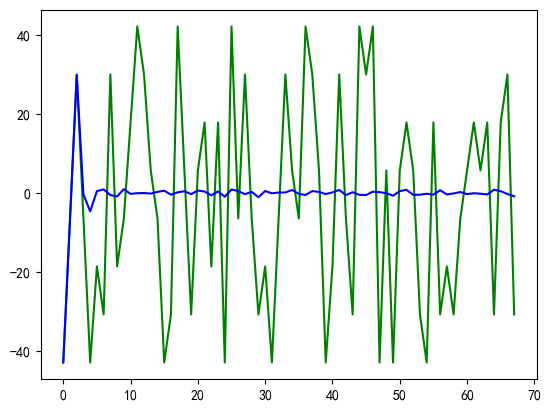

In [53]:
import matplotlib.pyplot as plt
import numpy as np
import hdf5storage
import math
from scipy.interpolate import make_interp_spline
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from Neural_Decoding.metrics import get_R2
from Neural_Decoding.metrics import get_rho
from Neural_Decoding.decoders import KalmanFilterDecoder,LSTMDecoder

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False  

file = 'indy_20160407_02.mat'
data = hdf5storage.loadmat(file, mat_dtype=True)
target_pos = data['target_pos']
cursor_pos = data['cursor_pos']
wf = (np.array([data['wf'][32][0]])).reshape(8092, 48)
wf1 = (np.array([data['wf'][32][1]])).reshape(9652, 48)
wf2 = (np.array([data['wf'][32][2]])).reshape(5310, 48)
t = data['t']
spike = (np.array([data['spikes'][32][1]])).reshape(9652, 1)
spike1 = (np.array([data['spikes'][32][2]])).reshape(5310, 1)

all_position = []
time_position = []
x = target_pos[0, 0]
y = target_pos[0, 1]
for i in range(target_pos.shape[0]):
    if target_pos[i, 0] != x and target_pos[i, 1] != y:
        all_position.append(target_pos[i, :])
        time_position.append(t[i])
        x = target_pos[i, 0]
        y = target_pos[i, 1]
all_position = np.array(all_position)
time_position = np.array(time_position)

neural_data = np.zeros([466,2])
for i in range(time_position.shape[0]):
    count1 = 0
    count2 = 0
    if i == 0:
        for j in spike:
            if j < time_position[0]:
                count1+=1
        for k in spike1:
            if k < time_position[0]:
                count2+=1
    else:
        for j in spike:
            if time_position[i-1] < j < time_position[i]:
                count1+=1
        for k in spike1:
            if time_position[i-1] < k < time_position[i]:
                count2+=1
    neural_data[i, 0] = count1
    neural_data[i, 1] = count2
pos_binned = all_position[0:466, :]
neural_data = np.array(neural_data)

lag=-1

X_kf=neural_data

temp=np.diff(pos_binned,axis=0)
vels_binned=np.concatenate((temp,temp[-1:,:]),axis=0)
temp2=np.diff(vels_binned,axis=0)
acc_binned=np.concatenate((temp2,temp2[-1:,:]),axis=0)
y_kf=np.concatenate((pos_binned,vels_binned,acc_binned),axis=1)

rmv_time=np.where(np.isnan(y_kf[:,0]) | np.isnan(y_kf[:,1]))
X_kf=np.delete(X_kf,rmv_time,0)
y_kf=np.delete(y_kf,rmv_time,0)

num_examples=X_kf.shape[0]
if lag<0:
    y_kf=y_kf[-lag:,:]
    X_kf=X_kf[0:num_examples+lag,:]
if lag>0:
    y_kf=y_kf[0:num_examples-lag,:]
    X_kf=X_kf[lag:num_examples,:]

training_range = [0, 0.5]
valid_range = [0.5, 0.65]
testing_range = [0.65, 0.8]

num_examples_kf = X_kf.shape[0]

training_set = np.arange(np.int_(np.round(training_range[0] * num_examples_kf)) + 1,
                         np.int_(np.round(training_range[1] * num_examples_kf)) - 1)
testing_set = np.arange(np.int_(np.round(testing_range[0] * num_examples_kf)) + 1,
                        np.int_(np.round(testing_range[1] * num_examples_kf)) - 1)
valid_set = np.arange(np.int_(np.round(valid_range[0] * num_examples_kf)) + 1,
                      np.int_(np.round(valid_range[1] * num_examples_kf)) - 1)

X_kf_train = X_kf[training_set, :]
y_kf_train = y_kf[training_set, :]

X_kf_test = X_kf[testing_set, :]
y_kf_test = y_kf[testing_set, :]

X_kf_valid = X_kf[valid_set, :]
y_kf_valid = y_kf[valid_set, :]

X_kf_train_mean=np.nanmean(X_kf_train,axis=0)
X_kf_train_std=np.nanstd(X_kf_train,axis=0)
X_kf_train=(X_kf_train-X_kf_train_mean)/X_kf_train_std
X_kf_test=(X_kf_test-X_kf_train_mean)/X_kf_train_std
X_kf_valid=(X_kf_valid-X_kf_train_mean)/X_kf_train_std

y_kf_train_mean=np.mean(y_kf_train,axis=0)
y_kf_train=y_kf_train-y_kf_train_mean
y_kf_test=y_kf_test-y_kf_train_mean
y_kf_valid=y_kf_valid-y_kf_train_mean

model_kf=KalmanFilterDecoder(C=5)

model_kf.fit(X_kf_train,y_kf_train)

y_valid_predicted_kf=model_kf.predict(X_kf_valid,y_kf_valid)

R2_kf=get_R2(y_kf_valid,y_valid_predicted_kf)

rho_kf=get_rho(y_kf_valid,y_valid_predicted_kf)

fig_x_kf=plt.figure()
plt.plot(y_kf_valid[:,1],'g')
plt.plot(y_valid_predicted_kf[:,1],'b')
plt.show()

D:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


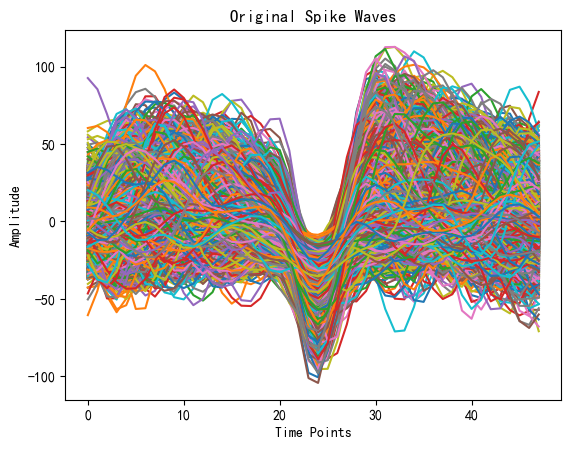

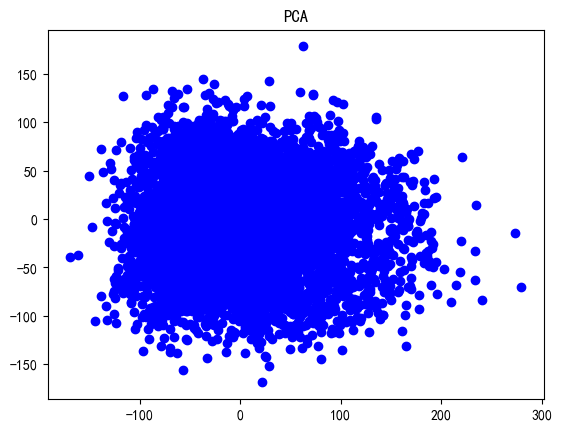

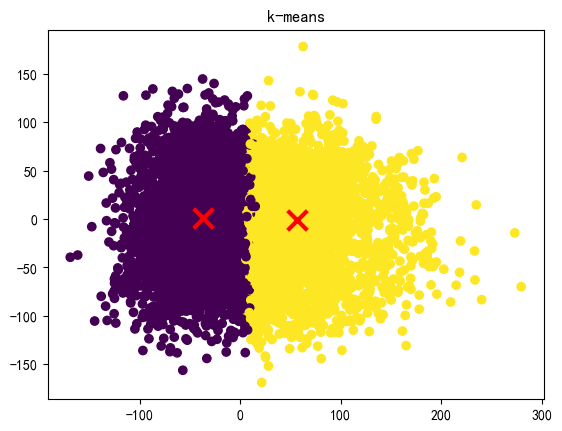

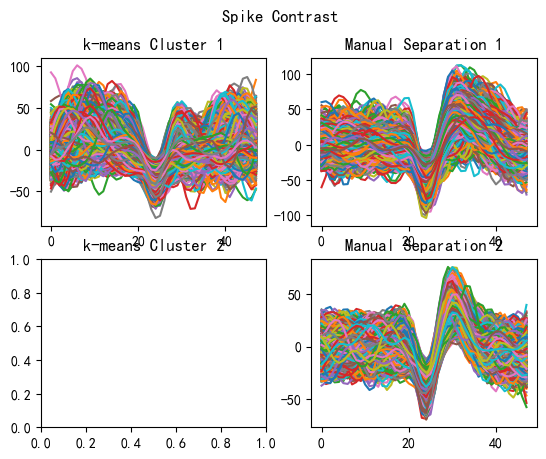

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import hdf5storage
import math
from scipy.interpolate import make_interp_spline
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Load the data
file = 'indy_20160407_02.mat'
data = hdf5storage.loadmat(file, mat_dtype=True)

# Extract relevant data
target_pos = data['target_pos']
cursor_pos = data['cursor_pos']
wf = data['wf'][32][0].reshape(-1, 48)
wf1 = data['wf'][32][1].reshape(-1, 48)
wf2 = data['wf'][32][2].reshape(-1, 48)
t = data['t'].flatten()
spike = data['spikes'][32][1].reshape(-1, 1)
spike1 = data['spikes'][32][2].reshape(-1, 1)

# Calculate target hit times
target_loc = [-30, 56.4286]
target_time = [i for i, pos in enumerate(cursor_pos) if np.linalg.norm(target_loc - pos[:2]) < 1]

# Create raster plot data
def create_raster_matrix(spike_data, event_times, pre=0.2, post=1.2):
    raster_matrix = np.zeros((len(event_times), 1000))
    for i, event_time in enumerate(event_times):
        spikes = spike_data[(spike_data > event_time - pre) & (spike_data < event_time + post)] - event_time
        raster_matrix[i, :len(spikes)] = spikes.flatten()
    return raster_matrix

valid_target_time = t[target_time]
raster_matrix = create_raster_matrix(spike, valid_target_time)

# Calculate angles and count spikes per angle
def calc_angles(target_positions):
    angles = np.arctan2(target_positions[1:, 1] - target_positions[:-1, 1],
                        target_positions[1:, 0] - target_positions[:-1, 0])
    angles_deg = np.degrees(angles) % 360
    return angles_deg

angles = calc_angles(target_pos)
angle_bins = np.digitize(angles, bins=np.arange(0, 360, 45))

# Count spikes in each angular direction
def count_spikes_per_angle(spike_data, time_positions, angle_bins):
    angle_counts = np.zeros(8)
    for i in range(1, 9):
        bin_indices = np.where(angle_bins == i)[0]
        count = 0
        duration = 0
        for j in range(len(bin_indices) - 1):
            start_time = time_positions[bin_indices[j]]
            end_time = time_positions[bin_indices[j + 1]]
            count += np.sum((spike_data > start_time) & (spike_data < end_time))
            duration += end_time - start_time
        if duration > 0:
            angle_counts[i - 1] = count / duration
        else:
            angle_counts[i - 1] = 0
    return angle_counts

angle_counts = count_spikes_per_angle(spike, t, angle_bins)
x_new = np.linspace(1, 8, 300)
y_smooth = make_interp_spline(range(1, 9), angle_counts)(x_new)

# Spike waveform original signal plot
plt.figure()
for waveform in wf:
    plt.plot(waveform)
plt.xlabel('Time Points')
plt.ylabel('Amplitude')
plt.title('Original Spike Waves')

# PCA dimensionality reduction and visualization
pca = PCA(n_components=4)
X_new = pca.fit_transform(wf)
plt.figure()
plt.scatter(X_new[:, 0], X_new[:, 1], c='blue')
plt.title('PCA')

# K-means clustering
kmeans = KMeans(n_clusters=2)
kmeans.fit(X_new)
centers = kmeans.cluster_centers_
labels = kmeans.labels_

# Visualize k-means results
plt.figure()
plt.scatter(X_new[:, 0], X_new[:, 1], c=labels, cmap='viridis')
plt.scatter(centers[:, 0], centers[:, 1], marker='x', s=200, linewidths=3, color='red')
plt.title('k-means')

# Show differences in spike signals separated by k-means and manual separation
fig, ax = plt.subplots(2, 2)
for i, label in enumerate(labels):
    ax[label // 2][label % 2].plot(wf[i, :])
ax[0][0].set_title('k-means Cluster 1')
ax[1][0].set_title('k-means Cluster 2')
for waveform in wf1:
    ax[0][1].plot(waveform)
ax[0][1].set_title('Manual Separation 1')
for waveform in wf2:
    ax[1][1].plot(waveform)
ax[1][1].set_title('Manual Separation 2')
plt.suptitle('Spike Contrast')
plt.show()
